## Tecnologias e Aplicações
## Trabalho prático 2, Março 2020

### German Trafic Sign Recognition using CNN

Using the GTSR dataset for recognition of traffic signs, we created a convolutional neural network that recognizes traffic signs.

To improve the model the following elements were changed:
- batch size
- image size
- the number of layers (depth of the network):
    - Padding, and its size
    - number and size of filters for the convolution layers
    - How many dropouts, and its percentage
    - How many dense layers
- number of epochs

These elements are discussed below.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

In [2]:
dataset_path = "gtsrb/"

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

### Image size

Bigger images means more computation operations per layer as well as more memory requirements, but better filters. So we choose 64 x 64 images.

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 64

### Prepare to load images

Getting all the class names in a numpy array.

In [4]:
data_dir = pathlib.Path(dataset_path + "train_images/")
trainClassNames = np.array(os.listdir(data_dir))

data_dir = pathlib.Path(dataset_path + "val_images/")
valClassNames = np.array(os.listdir(data_dir))

print("training", trainClassNames)
print("validation", valClassNames)

training ['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']
validation ['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


### Auxiliary functions 

#### get_label
Gets the label of an image, through its path. This function returns an array of Booleans where all elements are False except one, and the position of that True represents a class.

#### decode_img

Process the image for better performance and usage, by converting to uint8, making it binary and resizing.

#### get_bytes_and_label

Receives a path for an image and returns the image and its label.

In [5]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == valClassNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMAGE_SIZE,IMAGE_SIZE])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Loading images

The images are loaded to a Dataset from Keras and shuffled.

#### Validation set

The validation set was built by hand, by cutting 20% of each class of the train set. Each 20% was put in a folder with the corresponding class name, inside the validation set folder.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(dataset_path + "train_images/*/*.png")
train_dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

listset = tf.data.Dataset.list_files(dataset_path + "val_images/*/*.png")
val_dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

listset = tf.data.Dataset.list_files(dataset_path + "test_images/*/*.png")
test_dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

### Information about image shape and size of training set

In [7]:
for image, label in train_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  
dataset_length = [i for i,_ in enumerate(train_dataset)][-1] + 1
print("Total images in dataset: ",dataset_length)

val_length = [i for i,_ in enumerate(val_dataset)][-1] + 1
print("Total images in dataset: ",val_length)


Image shape:  (64, 64, 3)
Total images in dataset:  32060
Total images in dataset:  7844


## Data augmentation

Data augmentation is an integral process in deep learning, as in deep learning we need large amounts of data and in some cases it is not feasible to collect thousands or millions of images, so data augmentation comes to the rescue.

Some methods:
- Translation
- Rotation
- Shearing
    - Shear X
    - Shear Y
- Scaling
- Cropping
- Flipping
    - Vertical Flipping
    - Horizontal Flipping
- Brightness Level
- Noise
- Generators or neural networks

The last one is used to alter the image domain, for example, make a photo taken in summer look like it was taken in winter.

Some methods previously mentioned, cause empty space to appear in the images (like rotation and translation). To fill the  empty space in an image it can be used interpolation, like:
- Constant: makes the empty space black or white (default)
- Edge: the edge values of the image are extended after the boundary. This method can work for mild translations
- Reflect: the image pixel values are reflected along the image boundary. This method is useful for continuous or natural backgrounds containing trees, mountains etc
- Wrap: the image is just repeated beyond its boundary, as if it’s being tiled. This method is not as popularly used as the rest as it does not make sense for a lot of scenarios.

For the GTSR, there are some methods that aren't appropriated, like the flip or rotation with bigger angles, because flipping some traffic signs changes the sign class.

Our data augmentation consists of rotation, translation, an adjustment in the hue values, saturation, and RGB values, and an increase of the brightness. The rotation and translation use random values, between acceptable values, making the images with different rotations and translations, because the random values ​​are always different.

In [8]:
import random

#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa

def process_image(image, label):
    
    # Devolde um numero aleatorio, atraves de uma distribuição normal, de -0.25 até 0.249..9
    r = tf.random.uniform(shape=(), minval=0, maxval=1)* 0.5 - 0.25
    
    # Aplica uma rotação no sentido contrario dos relogios em radianos
    # ou seja, aplica uma rotação de entre -14.324 a 14.324
    image = tfa.image.rotate(image, r)
    
    # Devolde um numero de -10 até 9.(9)
    rx = tf.random.uniform(shape=(), minval=0, maxval=1) * 20 - 10
    # Devolde um numero de -4 até 3.(9)
    ry = tf.random.uniform(shape=(), minval=0, maxval=1) * 8 - 4
    # Aplica uma translação com o vetor [rx, ry]
    image = tfa.image.translate(image, [rx, ry])
    
    # Ajusta o hue, saturação e rgb
    # o hue é escolhido aleatoriamente num intervalo [-0.3, 0,3]
    # a saturaçao é escolhida aleatoriamente num intervalo [0.9, 1,1]
    # scale_value é escolhido aleatoriamente num intervalo [0.9, 1,3]
    image = tfa.image.random_hsv_in_yiq(image, 0.3, 0.9, 1.1, 0.9, 1.3)
    
    # Aumenta a brightness com um valor aleatorio de [-0.2, 0.8[
    # Todos os ... que sejam abaixo de 0.1 passam a ser 0.1
    image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

### Preparing datasets

The datasets are prepared for better performance. Each image of the train and validation set is modified, using data augmentation methods with random values. In order to use the GPU for processing each image asynchronously in parallel, it is passed value 8 to the **num_parallell_calls**.

In [9]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = dataset_length)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.map(process_image, num_parallel_calls=8)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.repeat()

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(buffer_size = val_length)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.map(process_image, num_parallel_calls=8)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.repeat()

test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)

### Show a batch of training images

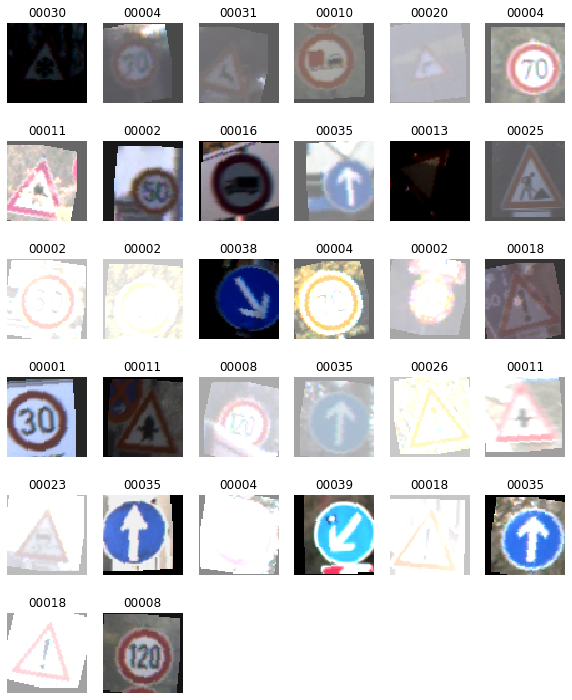

In [10]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(valClassNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(train_dataset))        
show_batch(image_batch, label_batch.numpy())

#### Number of Layers
One good strategy is to add layers to the model util it starts to overfit.

#### Padding
Bigger padding implies that the neural network must learn that the padding isn't relevant for classification. So we used padding with size one because it's the smallest padding and this way some pixels from the image are not ignored.

#### Conv2D
For the Conv2D layers, the number of filters starts at 64 and goes up, doubling it every layer. This serves to catch fewer filters at begging and more filters at the end. The Neural Network finds some features that are common by some signs at the beginning and more features at the end making the neural network recognize each sign individually.

#### Dropouts
Dropouts are used to maintain randomness. It helps to overcome overfit.

#### Denses
There are three dense layers, one with 256 nodes, one with 100 nodes and one with 43 nodes. The first one and the second one are used to find association that can exist among any feature to any other feature in a data point. The third one gives the class name of the image.

#### Model
The model consists of 4 major groups. The first three groups are equal and consist of the following sequence:
1. Conv2D
2. MaxPooling2D
3. BatchNormalization
4. Dropout

The fourth group consist of three dense layers with a BatchNormalization and a Dropout between.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

def cnn55D3L2FC(classCount, imgSize, channels):
    
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(3,3),input_shape=(imgSize, imgSize, channels)))
    model.add(Conv2D(64, (5, 5), padding='same',activation='relu'))                        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    
    model.add(Conv2D(128, (3, 3),padding='same', activation='relu') )                       
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    
    model.add(Conv2D(256, (3, 3),padding='same', activation='relu') )                       
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #Fully conected layer
    model.add(Flatten())
    
    #Three more layers
    model.add(Dense(256, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(100, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(classCount, activation='softmax'))
   

    #opt = Adam(lr=0.001)
    model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    
    return model

model = cnn55D3L2FC(43, IMAGE_SIZE, 3)


### Draw a diagram of the network

This requires installing some packages, namely graphviz

In [12]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Display a table with model information

When building a model kee an eye on the number of trainable parameters. Try to keep it below 10 million

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 35, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0

### Train the network

#### **Number of epochs**
Similar to the number of layers, a good strategy is to increase the number of epochs until it starts to overfit.

In [14]:
from keras.callbacks.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
            monitor='val_categorical_accuracy',
            min_delta=0,
            patience=2,
            verbose=3,
            mode='max'
        )
    ]

history = model.fit(train_dataset, steps_per_epoch = dataset_length/BATCH_SIZE, epochs=40, validation_data = val_dataset, validation_steps=val_length/BATCH_SIZE)

Using TensorFlow backend.


Train for 1001.875 steps, validate for 245.125 steps
Epoch 1/40
1002/1001 [==============================] - 102s 102ms/step - loss: 3.1925 - categorical_accuracy: 0.1823 - val_loss: 2.1400 - val_categorical_accuracy: 0.3418
Epoch 2/40
1002/1001 [==============================] - 79s 79ms/step - loss: 1.9965 - categorical_accuracy: 0.3865 - val_loss: 1.5205 - val_categorical_accuracy: 0.5379
Epoch 3/40
1002/1001 [==============================] - 77s 77ms/step - loss: 1.3758 - categorical_accuracy: 0.5774 - val_loss: 1.0471 - val_categorical_accuracy: 0.6874
Epoch 4/40
1002/1001 [==============================] - 79s 78ms/step - loss: 0.9795 - categorical_accuracy: 0.7044 - val_loss: 0.8843 - val_categorical_accuracy: 0.7411
Epoch 5/40
1002/1001 [==============================] - 77s 77ms/step - loss: 0.7754 - categorical_accuracy: 0.7749 - val_loss: 0.7414 - val_categorical_accuracy: 0.7926
Epoch 6/40
1002/1001 [==============================] - 74s 74ms/step - loss: 0.6534 - categori

### Plot the training history

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


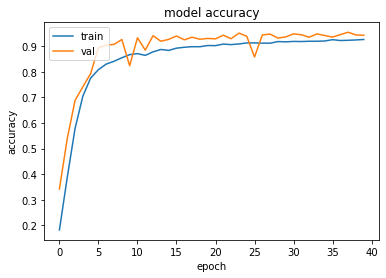

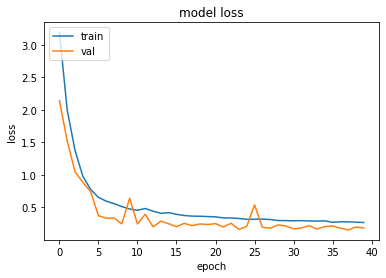

In [15]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the model on the test set

This is the accuracy number that really matters. The accuracy without data augmentation is 98.2%.

With data augmentation the accuracy is 99.05%. Although this value is greater than the other accuracy, this CNN has underfitting (the validation accuracy is greater than training accuracy), due to the fact that the architecture is not very complex, that is, not very deep, and because the number of epochs is low.

Training the CNN with the new validation set, without data augmentation, outputs a result with 98.6% accuracy, concluding that a good validation set is important for the training of the network.

In [16]:
model.evaluate(test_dataset)

395/395 [==============================] - 11s 28ms/step - loss: 0.0329 - categorical_accuracy: 0.9905


[0.03291421449565733, 0.99049884]